# In Depth: k-Means Clustering

В предыдущих нескольких разделах мы рассмотрели одну категорию моделей машинного обучения без учителя: уменьшение размерности.
Здесь мы перейдем к другому классу моделей машинного обучения без учителя: алгоритмам кластеризации.
Алгоритмы кластеризации стремятся узнать на основе свойств данных оптимальное деление или дискретную маркировку групп точек.

Многие алгоритмы кластеризации доступны в Scikit-Learn и других источниках, но, возможно, самым простым для понимания является алгоритм, известный как кластеризация k-средних*, который реализован в sklearn.cluster.KMeans.

Начнем со стандартного импорта:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

Алгоритм *k*-средних ищет заранее определенное количество кластеров в немаркированном многомерном наборе данных.
Это достигается с помощью простой концепции того, как выглядит оптимальная кластеризация:

- «Центр кластера» — это среднее арифметическое всех точек, принадлежащих кластеру.
- Каждая точка ближе к своему центру кластера, чем к центрам других кластеров.

Эти два предположения лежат в основе модели *k*-средних.
Вскоре мы углубимся в то, *как* алгоритм достигает этого решения, а пока давайте взглянем на простой набор данных и посмотрим на результат *k*-средних.

Во-первых, давайте создадим двумерный набор данных, содержащий четыре отдельных больших двоичных объекта.
Чтобы подчеркнуть, что это неконтролируемый алгоритм, мы не будем использовать метки в визуализации.

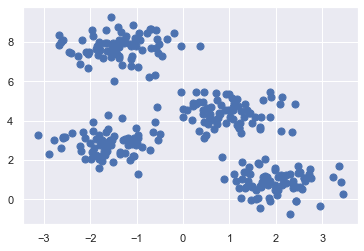

In [3]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

На глаз относительно легко выделить четыре кластера.
Алгоритм *k*-средних делает это автоматически, а в Scikit-Learn используется типичный API оценки:

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Давайте визуализируем результаты, нанеся данные, окрашенные этими метками.
Мы также построим центры кластеров, определенные оценщиком *k*-средних:

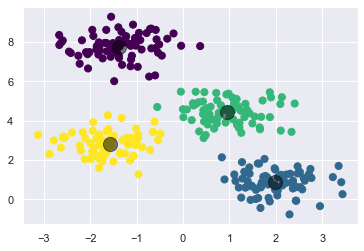

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Хорошая новость заключается в том, что алгоритм *k*-средних (по крайней мере, в этом простом случае) присваивает точки кластерам очень похоже на то, как мы могли бы присваивать их на глаз.
Но вы можете удивиться, как этот алгоритм так быстро находит эти кластеры! В конце концов, количество возможных комбинаций назначений кластеров экспоненциально зависит от количества точек данных — исчерпывающий поиск был бы очень и очень дорогостоящим.
К счастью для нас, такой исчерпывающий поиск не требуется: вместо этого типичный подход к *k*-средним включает интуитивный итеративный подход, известный как *ожидание-максимизация*.

## k-Means Algorithm: Expectation–Maximization

Ожидание-максимизация (E-M) — это мощный алгоритм, который используется в различных контекстах науки о данных.
*k*-means — это особенно простое и понятное приложение алгоритма, и мы кратко рассмотрим его здесь.
Короче говоря, подход максимизации ожидания здесь состоит из следующей процедуры:

1. Угадайте несколько центров кластеров
2. Повторяйте до тех пор, пока не сойдется
   1. *E-Step*: назначьте точки ближайшему центру кластера.
   2. *M-шаг*: установите центры кластеров на среднее

Здесь «E-шаг» или «Шаг ожидания» назван так, потому что он включает обновление нашего ожидания того, к какому кластеру принадлежит каждая точка.
«М-шаг» или «шаг максимизации» назван так потому, что он включает в себя максимизацию некоторой фитнес-функции, которая определяет расположение центров кластеров — в данном случае эта максимизация достигается путем взятия простого среднего значения данных в каждом кластере. .

Литература об этом алгоритме обширна, но ее можно обобщить следующим образом: при типичных обстоятельствах каждое повторение Е-шага и М-шага всегда приводит к лучшей оценке характеристик кластера.

Мы можем визуализировать алгоритм, как показано на следующем рисунке.
Для конкретной инициализации, показанной здесь, кластеры сходятся всего за три итерации.
Для интерактивной версии этой фигуры обратитесь к коду в [Приложении] (06.00-Рисунок-Code.ipynb#Interactive-K-Means).

![(run code in Appendix to generate image)](figures/05.11-expectation-maximization.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Expectation-Maximization)

Алгоритм *k*-средних достаточно прост, поэтому мы можем записать его в несколько строк кода.
Ниже приведена очень простая реализация:

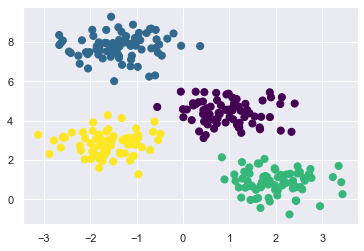

In [16]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Большинство хорошо протестированных реализаций под капотом делают немного больше, но предыдущая функция дает суть подхода максимизации ожидания.

### Предостережения ожидания – максимизация

Есть несколько проблем, о которых следует помнить при использовании алгоритма максимизации ожидания.

#### Глобально оптимальный результат может быть не достигнут
Во-первых, хотя процедура Э-М гарантированно улучшает результат на каждом этапе, нет никакой гарантии, что она приведет к *глобальному* лучшему решению.
Например, если мы используем другое случайное начальное число в нашей простой процедуре, конкретные начальные предположения приведут к плохим результатам:

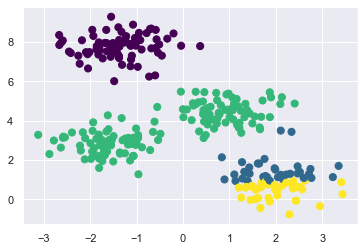

In [17]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Здесь подход ЭМ сошелся, но не сошелся к глобально оптимальной конфигурации. По этой причине алгоритм обычно запускается для нескольких начальных догадок, как это действительно делает Scikit-Learn по умолчанию (устанавливается параметром ``n_init``, который по умолчанию равен 10).

#### Количество кластеров должно быть выбрано заранее
Другая распространенная проблема с *k*-means заключается в том, что вы должны сообщить ему, сколько кластеров вы ожидаете: он не может узнать количество кластеров из данных.
Например, если мы попросим алгоритм идентифицировать шесть кластеров, он с радостью продолжит работу и найдет шесть лучших кластеров:

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


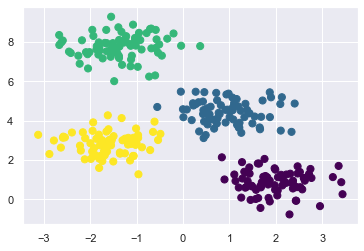

In [18]:
labels = KMeans(4, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Имеет ли значение результат — вопрос, на который трудно ответить однозначно; один подход, который является довольно интуитивным, но который мы не будем здесь обсуждать, называется [анализ силуэта] (http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

В качестве альтернативы вы можете использовать более сложный алгоритм кластеризации, который имеет лучшую количественную меру пригодности на количество кластеров (например, смешанные модели Гаусса; см. [Подробно: модели смесей Гаусса] (05.12-Gaussian-Mixtures.ipynb)) или который *может* выбрать подходящее количество кластеров (например, DBSCAN, среднее смещение или аффинное распространение, все они доступны в подмодуле sklearn.cluster)

#### k-среднее значение ограничено линейными границами кластера
Фундаментальные допущения модели о *k*-средних (точки будут ближе к центру своего кластера, чем к другим) означают, что алгоритм часто будет неэффективным, если кластеры имеют сложную геометрию.

В частности, границы между кластерами *k*-средних всегда будут линейными, а это значит, что для более сложных границ это не удастся.
Рассмотрим следующие данные вместе с метками кластеров, найденными с помощью типичного подхода *k*-средних:

In [19]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


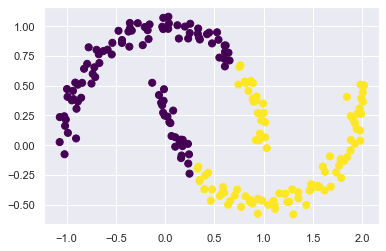

In [20]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Эта ситуация напоминает обсуждение в [Подробно: машины опорных векторов] (05.07-Support-Vector-Machines.ipynb), где мы использовали преобразование ядра для проецирования данных в более высокое измерение, где возможно линейное разделение.
Мы могли бы представить себе использование того же трюка, чтобы позволить *k*-средним обнаруживать нелинейные границы.

Одна версия этого кернелизованного *k*-средства реализована в Scikit-Learn в оценщике ``SpectralClustering``.
Он использует граф ближайших соседей для вычисления многомерного представления данных, а затем присваивает метки, используя алгоритм *k*-средних:

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


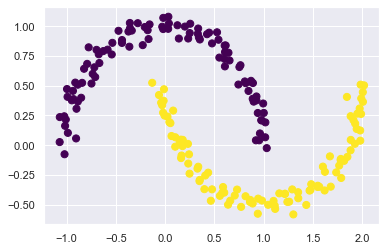

In [21]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Мы видим, что при таком подходе преобразования ядра ядерные *k*-средние способны находить более сложные нелинейные границы между кластерами.

#### k-средние могут быть медленными для большого количества выборок
Поскольку каждая итерация *k*-средних должна обращаться к каждой точке в наборе данных, алгоритм может быть относительно медленным по мере роста числа выборок.
Вы можете задаться вопросом, можно ли ослабить это требование использовать все данные на каждой итерации; например, вы можете просто использовать подмножество данных для обновления центров кластеров на каждом этапе.
В этом заключается идея пакетных алгоритмов *k*-средних, одна из форм которых реализована в sklearn.cluster.MiniBatchKMeans.
Интерфейс для этого такой же, как и для стандартного ``KMeans``; мы увидим пример его использования, когда продолжим наше обсуждение.

## Примеры

Принимая во внимание эти ограничения алгоритма, мы можем использовать *k*-средства в наших интересах в самых разных ситуациях.
Сейчас мы рассмотрим пару примеров.

### Пример 1: k-средние по цифрам

Для начала давайте взглянем на применение *k*-средних к тем же простым числовым данным, которые мы видели в [Подробно: деревья решений и случайные леса] (05.08-Random-Forests.ipynb) и [Подробно: основные Анализ компонентов](05.09-Анализ основных компонентов.ipynb).
Здесь мы попытаемся использовать *k*-средства, чтобы попытаться идентифицировать похожие цифры *без использования исходной информации этикетки*; это может быть похоже на первый шаг в извлечении значения из нового набора данных, о котором у вас нет никакой *априорной* информации о метках.

Мы начнем с загрузки цифр, а затем найдем кластеры KMeans.
Напомним, что цифры состоят из 1797 выборок с 64 признаками, где каждый из 64 признаков — это яркость одного пикселя в изображении 8×8:

In [22]:
import sklearn
print(sklearn.__version__)

1.1.3


In [85]:
!pip install -U scikit-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\biaspaltsau_aa\\Anaconda3\\Lib\\site-packages\\~klearn\\cluster\\_dbscan_inner.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [24]:
from sklearn.datasets import load_digits
from sklearn.cluster import BisectingKMeans #>1.1
digits = load_digits()
digits.data.shape

(1797, 64)

Кластеризацию можно выполнить, как мы делали раньше:

In [25]:
#kmeans = KMeans(n_clusters=10, random_state=0)
kmeans = BisectingKMeans(n_clusters=10, random_state=0)
#centers, indices = kmeans_plusplus(digits.data, n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

В результате получается 10 кластеров в 64 измерениях.
Обратите внимание, что центры кластеров сами по себе являются 64-мерными точками и сами могут быть интерпретированы как «типичная» цифра в кластере.
Давайте посмотрим, как выглядят эти кластерные центры:

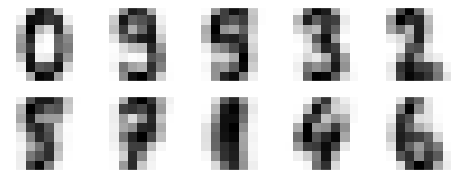

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Мы видим, что *даже без меток* ``KMeans`` может находить кластеры, центры которых являются распознаваемыми цифрами, возможно, за исключением 1 и 8.

Поскольку *k*-means ничего не знает об идентификаторе кластера, метки 0–9 могут быть переставлены.
Мы можем исправить это, сопоставив каждую изученную метку кластера с найденными в них истинными метками:

In [27]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Теперь мы можем проверить, насколько точной была наша неконтролируемая кластеризация при поиске похожих цифр в данных:

In [28]:
# KMeans
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

In [29]:
# BisectingKMeans ))
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

С помощью всего лишь простого алгоритма *k*-средних мы обнаружили правильную группировку для 80% входных цифр!
Давайте проверим матрицу путаницы для этого:

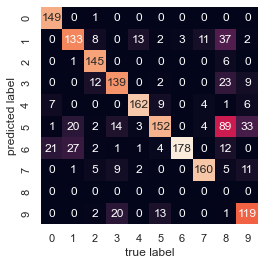

In [31]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Как и следовало ожидать от центров скоплений, которые мы визуализировали ранее, главная точка путаницы находится между восьмерками и единицами.
Но это по-прежнему показывает, что, используя *k*-средних, мы можем построить классификатор цифр *без ссылки на какие-либо известные метки*!

Просто для удовольствия, давайте попробуем продвинуться еще дальше.
Мы можем использовать алгоритм t-распределенного стохастического встраивания соседей (t-SNE) (упомянутый в [Углубленное: многообразное обучение] (05.10-Manifold-Learning.ipynb)) для предварительной обработки данных перед выполнением *k*-средних .
t-SNE — это нелинейный алгоритм встраивания, который особенно хорошо подходит для сохранения точек внутри кластеров.
Давайте посмотрим, как это делается:

In [32]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.9426822481914302

Это почти 92% точности классификации *без использования меток*.
В этом сила неконтролируемого обучения при осторожном использовании: оно может извлекать информацию из набора данных, которую было бы трудно сделать вручную или на глаз.

### Пример 2: *k*-средство для сжатия цвета

Одним из интересных применений кластеризации является сжатие цветов в изображениях.
Например, представьте, что у вас есть изображение с миллионами цветов.
В большинстве изображений большое количество цветов будет неиспользовано, и многие пиксели изображения будут иметь похожие или даже идентичные цвета.

Например, рассмотрите изображение, показанное на следующем рисунке, из модуля Scikit-Learn ``наборы данных`` (для того, чтобы это работало, у вас должен быть установлен пакет ``pillow`` Python).

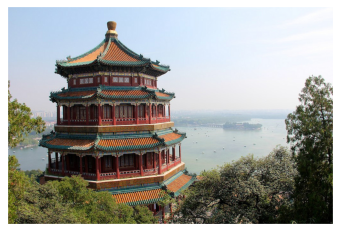

In [28]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Само изображение хранится в трехмерном массиве размера ``(высота, ширина, RGB)``, содержащем значения красного/синего/зеленого в виде целых чисел от 0 до 255:

In [29]:
china.shape

(427, 640, 3)

Мы можем рассматривать этот набор пикселей как облако точек в трехмерном цветовом пространстве.
Мы изменим форму данных на ``[n_samples x n_features]`` и изменим масштаб цветов так, чтобы они находились между 0 и 1:

In [30]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Мы можем визуализировать эти пиксели в этом цветовом пространстве, используя для эффективности подмножество из 10 000 пикселей:

In [31]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

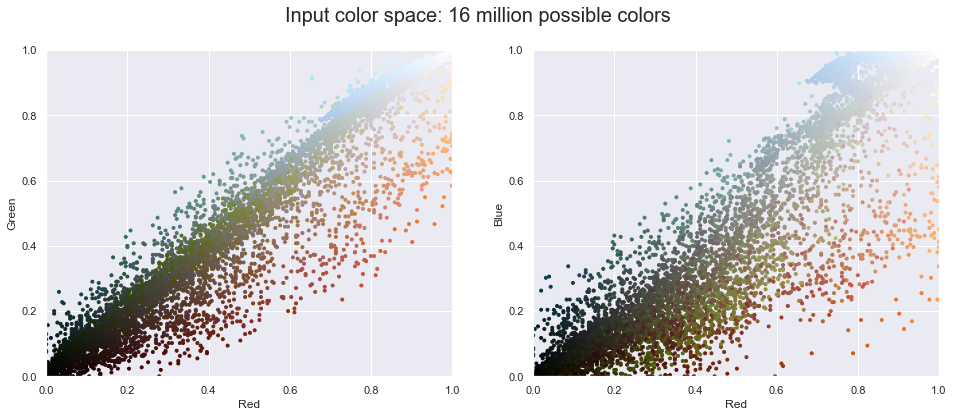

In [32]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Теперь давайте сократим эти 16 миллионов цветов до 16, используя *k*-среднее кластеризацию в пространстве пикселей.
Поскольку мы имеем дело с очень большим набором данных, мы будем использовать мини-пакет *k*-средних, который работает с подмножествами данных для вычисления результата намного быстрее, чем стандартный алгоритм *k*-средних:

In [23]:
data.shape

(273280, 3)

In [24]:
!pip install numpy==1.21.4  
##((

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\biaspaltsau_aa\\Anaconda3\\Lib\\site-packages\\numpy\\~-ibs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




  Using cached numpy-1.21.4-cp39-cp39-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [25]:
!pip install --upgrade --force-reinstall threadpoolctl

  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0


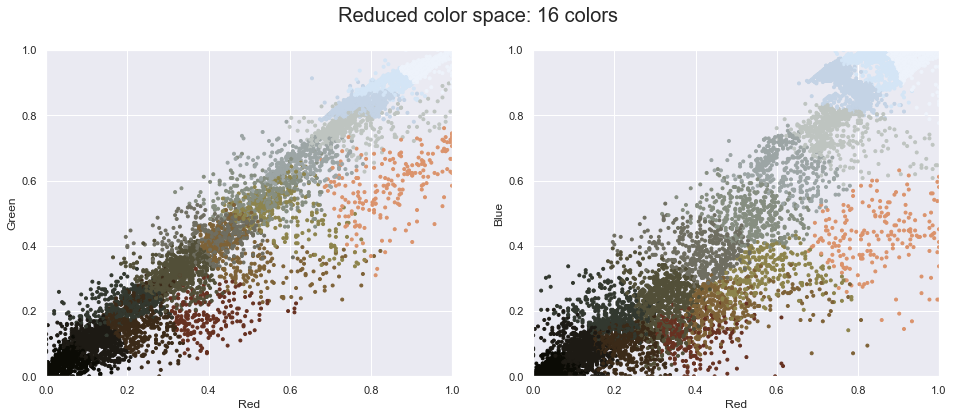

In [26]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

Результатом является перекрашивание исходных пикселей, где каждому пикселю назначается цвет его ближайшего центра кластера.
Отображение этих новых цветов в пространстве изображения, а не в пространстве пикселей, показывает нам эффект этого:

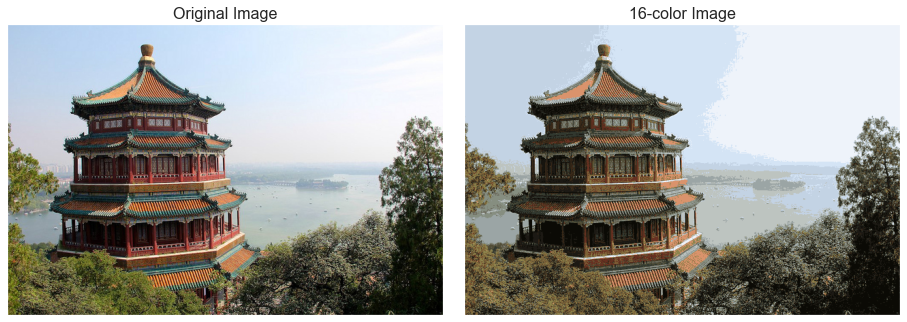

In [27]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Некоторые детали, безусловно, теряются на крайней правой панели, но в целом изображение все еще легко узнаваемо.
Это изображение справа имеет коэффициент сжатия около 1 миллиона!
Хотя это интересное применение *k*-средних, безусловно, есть лучший способ сжатия информации в изображениях.
Но пример показывает силу нестандартного мышления с неконтролируемыми методами, такими как *k*-средние.

---

In [52]:
from sklearn.datasets import make_blobs
import pandas as pd

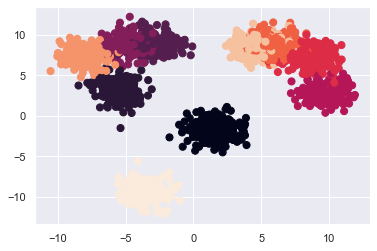

In [55]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=2000, centers=10)
plt.scatter(X[:, 0], X[:, 1],c=y_true, s=50);

In [56]:
pd.DataFrame(X).head()

,0,1
0,4.469603,9.064220
1,-2.206216,-7.414443
2,-0.780185,-1.621949
3,6.370255,8.663599
4,-2.665762,7.475170


In [57]:
import hdbscan

In [61]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)

In [62]:
clusterer.fit(X)

HDBSCAN(min_cluster_size=10)

In [63]:
clusterer.get_params()

{'algorithm': 'best',
 'allow_single_cluster': False,
 'alpha': 1.0,
 'approx_min_span_tree': True,
 'cluster_selection_epsilon': 0.0,
 'cluster_selection_method': 'eom',
 'core_dist_n_jobs': 4,
 'gen_min_span_tree': False,
 'leaf_size': 40,
 'match_reference_implementation': False,
 'max_cluster_size': 0,
 'memory': Memory(location=None),
 'metric': 'euclidean',
 'min_cluster_size': 10,
 'min_samples': None,
 'p': None,
 'prediction_data': False}

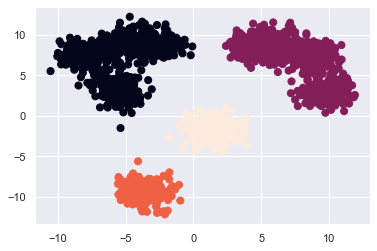

In [64]:

plt.scatter(X[:, 0], X[:, 1],c=clusterer.labels_, s=50);

---

kmeans_plusplus 